In [21]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=64, shuffle=True)
lr = 1e-1

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([64, 1, 28, 28])

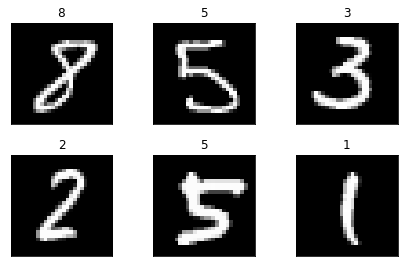

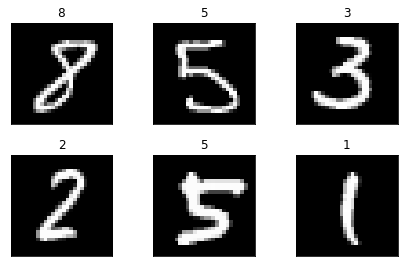

In [23]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title(example_targets[i].item())
  plt.xticks([])
  plt.yticks([])
fig

In [6]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
network = ConvolutionalNetwork().to(device)
optimizer = optim.SGD(network.parameters(), lr=lr)
epochs = 3

Using cuda device


In [8]:
def make_train_step(model, optimizer):
    def train_step(x,y):
        optimizer.zero_grad()
        yhat = model(x)
        loss_calculation = F.nll_loss(yhat, y)
        loss_calculation.backward()
        optimizer.step()
        return loss_calculation.item()
    return train_step

In [9]:
train_step = make_train_step(network, optimizer)
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]
log_interval = 10
network.train()
for epoch in range(epochs):
    for batch_idx, (train_value, train_label) in enumerate(train_loader):
        train_value = train_value.to(device)
        train_label = train_label.to(device)

        loss = train_step(train_value, train_label)
        if batch_idx % log_interval == 0:
         print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
           epoch, batch_idx * len(train_value), len(train_loader.dataset),
           100. * batch_idx / len(train_loader), loss))
         train_losses.append(loss)
         train_counter.append(
           (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
print(network.state_dict())

C:\Users\miki\AppData\Local\Temp\ipykernel_1988\573780117.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.327799
Train Epoch: 0 [640/60000 (1%)]	Loss: 2.297481
Train Epoch: 0 [1280/60000 (2%)]	Loss: 2.160720
Train Epoch: 0 [1920/60000 (3%)]	Loss: 1.863344
Train Epoch: 0 [2560/60000 (4%)]	Loss: 1.549726
Train Epoch: 0 [3200/60000 (5%)]	Loss: 1.284093
Train Epoch: 0 [3840/60000 (6%)]	Loss: 0.993610
Train Epoch: 0 [4480/60000 (7%)]	Loss: 1.056190
Train Epoch: 0 [5120/60000 (9%)]	Loss: 0.904825
Train Epoch: 0 [5760/60000 (10%)]	Loss: 0.845508
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.826013
Train Epoch: 0 [7040/60000 (12%)]	Loss: 0.840612
Train Epoch: 0 [7680/60000 (13%)]	Loss: 0.822936
Train Epoch: 0 [8320/60000 (14%)]	Loss: 0.737991
Train Epoch: 0 [8960/60000 (15%)]	Loss: 0.767956
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.861414
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.636594
Train Epoch: 0 [10880/60000 (18%)]	Loss: 0.777161
Train Epoch: 0 [11520/60000 (19%)]	Loss: 0.833912
Train Epoch: 0 [12160/60000 (20%)]	Loss: 0.678635
Train Epoch: 0 [12800/60000 (

In [17]:
network.eval()
test_loss = 0
correct = 0
with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
test_loss /= len(test_loader.dataset)
test_losses.append(test_loss)
print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

C:\Users\miki\AppData\Local\Temp\ipykernel_1988\573780117.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 0.0739, Accuracy: 9757/10000 (98%)



Text(0, 0.5, 'negative log likelihood loss')

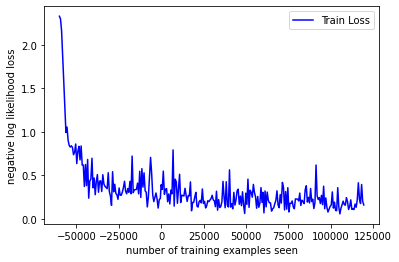

In [19]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')